## Imports

In [1]:
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline

# let's keep our keras backend tensorflow quiet
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
# for testing on CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

# keras imports for the dataset and building our neural network
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
import tensorflow as tf
import pdb
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## Plot some MNIST images

Text(0.5, 1.0, 'Pixel Value Distribution')

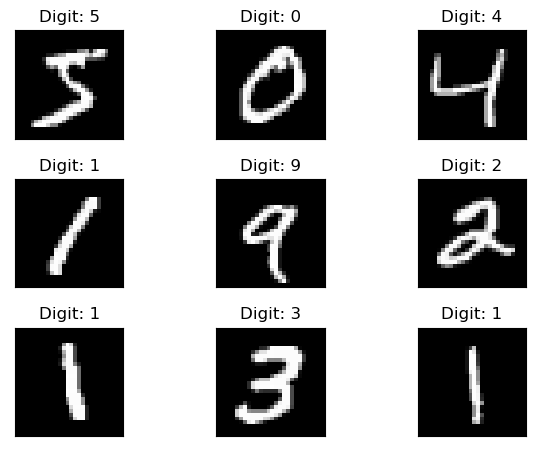

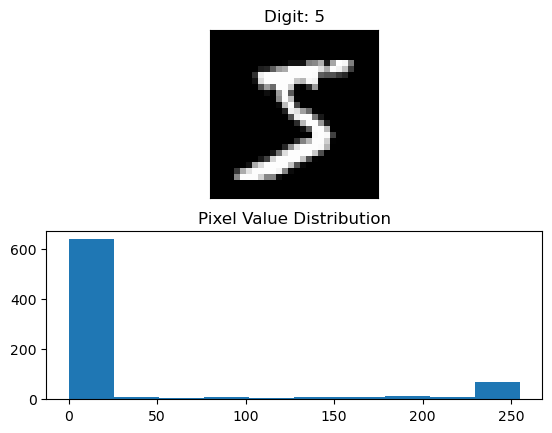

In [2]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
    
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(X_train[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(y_train[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(X_train[0].reshape(784))
plt.title("Pixel Value Distribution")

## Format and resize train and test set.

In [3]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)
Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


## Number of samples in different classes

In [4]:
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
      dtype=int64))


## Encode labels

In [5]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


## 1. Build a classifier and training.

In [6]:
# building a linear stack of layers with the sequential model
# Sparsity is only applied to the weights. Biases are kept aside out of sparsity.
#machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

model = Sequential()
model.add(Dense(256, input_shape=(784,)))
model.add(Activation('relu'))                            
#model.add(Dropout(0.2))

model.add(Dense(64))
model.add(Activation('relu'))
#model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.batches = []
        self.weight_save = []
        self.model_weights = model.get_weights()
        self.weight_masks = []
        for i in range(len(self.model_weights)):
            if i%2 == 0:
                self.random_mask = np.logical_and(np.random.randint(0,2,self.model_weights[i].shape), np.random.randint(0,2,self.model_weights[i].shape))
                self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                self.weight_masks.append(self.random_mask)
        for i in range(len(self.model_weights)):
            if i %2 == 0:
                self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
        model.set_weights(self.model_weights)
        self.weight_save.append(model.get_weights)       

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.batches.append(batch)
        self.model_weights = model.get_weights()
        for i in range(len(self.model_weights)):
            if i %2 == 0:
                self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
        model.set_weights(self.model_weights)
        self.weight_save.append(model.get_weights) 
       
                
l_history=LossHistory()
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=10, verbose=1,
          validation_data=(X_test, Y_test), callbacks = [es, l_history])

# saving the model
model_name = 'keras_mnist.h5'
model.save(model_name)
print('Saved trained model %s ' % model_name)

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 1.9010 - accuracy: 0.4268 - val_loss: 1.3525 - val_accuracy: 0.7020
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 1.1482 - accuracy: 0.7368 - val_loss: 0.9820 - val_accuracy: 0.7785
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.9072 - accuracy: 0.7675 - val_loss: 0.8163 - val_accuracy: 0.7956
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.7759 - accuracy: 0.7917 - val_loss: 0.7037 - val_accuracy: 0.8045
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6838 - accuracy: 0.7964 - val_loss: 0.6336 - val_accuracy: 0.8063
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6087 - accuracy: 0.8019 - val_loss: 0.5617 - val_accuracy: 0.8127
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.5639 - accuracy: 0.8015 - val_loss: 0.5375 - val_accuracy: 0.8163
Epoch 

#### Ploting the model performance.

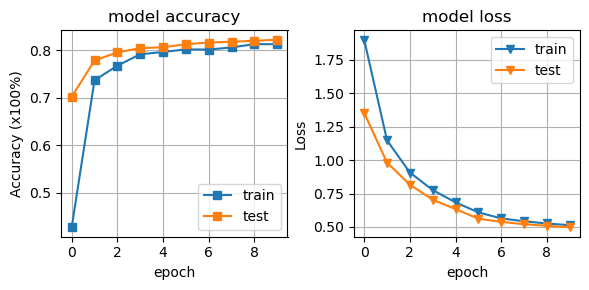

In [7]:
# plotting the metrics
fig = plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], marker = 's')
plt.plot(history.history['val_accuracy'], marker = 's')
plt.title('model accuracy')
plt.ylabel('Accuracy (x100%)')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], marker = 'v')
plt.plot(history.history['val_loss'], marker = 'v')
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()


In [8]:
len(l_history.weight_masks)

3

#### Sparsity percentage vs accuracy

In [9]:
#Sparsity percentage in each layer
for i in range(len(l_history.weight_masks)):
    print(f'sparsity in {i+1}th layer measured from mask:', 1-(np.count_nonzero(l_history.weight_masks[i])+0.0)/l_history.weight_masks[i].size)
    
print("---------------------------------------------------------------")    
for i in range(len(model.get_weights())):
    if i%2==0:
        print(f'Verification, sparsity in {i}th array from model.get_weights():',1-(np.count_nonzero(model.get_weights()[i])+0.0)/model.get_weights()[i].size)

sparsity in 1th layer measured from mask: 0.9684261399872449
sparsity in 2th layer measured from mask: 0.970947265625
sparsity in 3th layer measured from mask: 0.9703125
---------------------------------------------------------------
Verification, sparsity in 0th array from model.get_weights(): 0.9684261399872449
Verification, sparsity in 2th array from model.get_weights(): 0.970947265625
Verification, sparsity in 4th array from model.get_weights(): 0.9703125


#### Evaluating model performance

In [10]:
mnist_model = load_model(model_name)
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)

print("Test Loss {}.".format(loss_and_metrics[0]))
print("Test Accuracy {}%".format(loss_and_metrics[1]*100))

313/313 - 0s - loss: 0.4968 - accuracy: 0.8223 - 405ms/epoch - 1ms/step
Test Loss 0.49682319164276123.
Test Accuracy 82.23000168800354%


#### Re-load the trained model to evaluate it further.

313/313 [==============================] - 0s 1ms/step
8223  classified correctly
1777  classified incorrectly


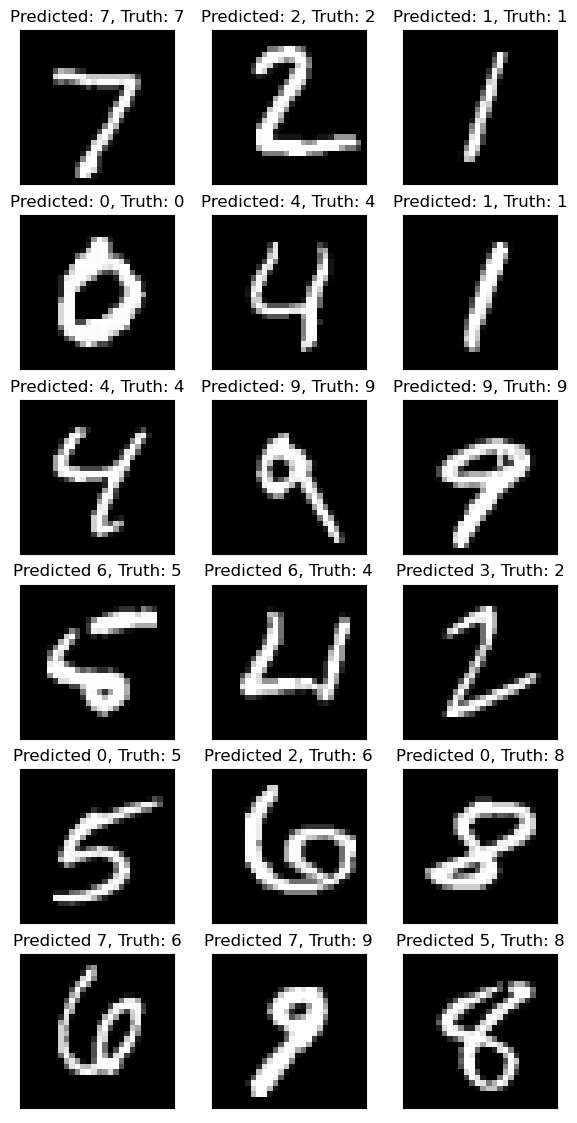

In [11]:
# load the model and create predictions on the test set
mnist_model = load_model(model_name)
predicted_classes = np.argmax(mnist_model.predict(X_test), axis=1)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])

# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])

## 2. Experimentation: Different sparsity and model performance measurement

In [12]:
#Sweeping the sparsity and measuring the model accuracy

model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))                            
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

model_losses = []
model_accs = []
layerwise_sparsity = []
Layerwise_sparsity = []
model_sparsity = []
for sparsity in range(10):
    print('Model training for sparsity # {0}'.format(sparsity+1))
    class LossHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.losses = []
            self.batches = []
            self.weight_save = []
            self.model_weights = model.get_weights()
            self.weight_masks = []
            for i in range(len(self.model_weights)):
                if i%2 == 0:
                    self.random_mask = np.logical_and(np.random.randint(0,2,self.model_weights[i].shape), np.random.randint(0,2,self.model_weights[i].shape))
                    for j in range(sparsity):
                        self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                    self.weight_masks.append(self.random_mask)
            for i in range(len(self.model_weights)):
                if i == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights)       

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
            self.batches.append(batch)
            self.model_weights = model.get_weights()
            for i in range(len(self.model_weights)):
                if i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights) 

    l_history=LossHistory()
    history = model.fit(X_train, Y_train,
              batch_size=128, epochs=10, verbose=0,
              validation_data=(X_test, Y_test), callbacks = [es, l_history])

    loss_and_metrics = model.evaluate(X_test, Y_test, verbose=2)
    model_losses.append(loss_and_metrics[0])
    model_accs.append(loss_and_metrics[1])
    
    for i in range(len(model.get_weights())):
        if i%2==0:
            layerwise_sparsity.append(1 - (np.count_nonzero(model.get_weights()[i])+0.0)/model.get_weights()[i].size)
    model_sparsity.append(np.mean(layerwise_sparsity))
    Layerwise_sparsity.append(layerwise_sparsity)
    layerwise_sparsity = []


Model training for sparsity # 1
313/313 - 0s - loss: 0.0714 - accuracy: 0.9786 - 380ms/epoch - 1ms/step
Model training for sparsity # 2
313/313 - 0s - loss: 0.0775 - accuracy: 0.9764 - 361ms/epoch - 1ms/step
Model training for sparsity # 3
313/313 - 0s - loss: 0.1157 - accuracy: 0.9660 - 382ms/epoch - 1ms/step
Model training for sparsity # 4
313/313 - 0s - loss: 0.2189 - accuracy: 0.9379 - 388ms/epoch - 1ms/step
Model training for sparsity # 5
313/313 - 0s - loss: 0.3801 - accuracy: 0.8889 - 376ms/epoch - 1ms/step
Model training for sparsity # 6
313/313 - 0s - loss: 1.4571 - accuracy: 0.5055 - 376ms/epoch - 1ms/step
Model training for sparsity # 7
313/313 - 0s - loss: 2.1248 - accuracy: 0.1917 - 495ms/epoch - 2ms/step
Model training for sparsity # 8
313/313 - 0s - loss: 2.2640 - accuracy: 0.1791 - 436ms/epoch - 1ms/step
Model training for sparsity # 9
313/313 - 0s - loss: 2.3010 - accuracy: 0.1135 - 427ms/epoch - 1ms/step
Model training for sparsity # 10
313/313 - 0s - loss: 2.3010 - a

In [13]:
for (i,j,k) in zip(model_sparsity,model_accs,model_losses):
    print(f'sparsity = {round(i,5)}, Test accuracy = {round(j,5)}, Test loss = {round(k,5)}')

sparsity = 0.74995, Test accuracy = 0.9786, Test loss = 0.07145
sparsity = 0.88144, Test accuracy = 0.9764, Test loss = 0.07752
sparsity = 0.94405, Test accuracy = 0.966, Test loss = 0.11568
sparsity = 0.97899, Test accuracy = 0.9379, Test loss = 0.21891
sparsity = 0.98923, Test accuracy = 0.8889, Test loss = 0.38007
sparsity = 0.9966, Test accuracy = 0.5055, Test loss = 1.4571
sparsity = 0.99877, Test accuracy = 0.1917, Test loss = 2.12478
sparsity = 0.99944, Test accuracy = 0.1791, Test loss = 2.264
sparsity = 0.99999, Test accuracy = 0.1135, Test loss = 2.30102
sparsity = 0.99987, Test accuracy = 0.1135, Test loss = 2.30103


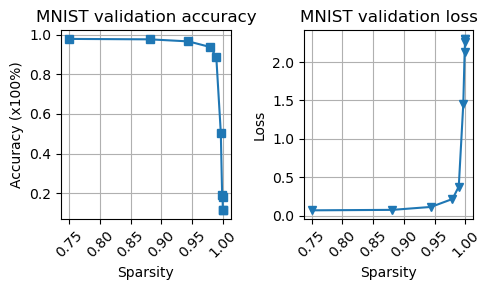

In [29]:
# plotting the metrics
fig = plt.figure(figsize = (5,3))
plt.subplot(1,2,1)
plt.plot(model_sparsity, model_accs, marker = 's')
plt.title('MNIST validation accuracy')
plt.grid()
plt.ylabel('Accuracy (x100%)')
plt.xlabel('Sparsity')
plt.xticks([0.75,0.8, 0.85, 0.9, 0.95, 1], rotation = 45)
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(model_sparsity, model_losses, marker = 'v')
plt.title('MNIST validation loss')
plt.ylabel('Loss')
plt.xlabel('Sparsity')
plt.grid()
plt.xticks([0.75,0.8, 0.85, 0.9, 0.95, 1], rotation = 45)
plt.tight_layout()
plt.savefig('MNIST_sparsity_sweep.pdf')

## 3. Rewiring the connections in sparse model.

In [30]:
import random
import pdb
Rewiring_dict = {}
saved_mask_from_iter1 = []
for re_wiring_iter in range(10):
    print('Training for re-wiring iteration: ', re_wiring_iter)
    model = Sequential()
    model.add(Dense(256, input_shape=(784,)))
    model.add(Activation('relu'))                            
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=50)

    class LossHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.losses = []
            self.batches = []
            self.weight_save = []
            self.model_weights = model.get_weights()
            self.weight_masks = []
            for i in range(len(self.model_weights)):
                if int(i%2) == 0:
                    if re_wiring_iter == 0:
                        self.random_mask = np.logical_and(np.random.randint(0,2,self.model_weights[i].shape), np.random.randint(0,2,self.model_weights[i].shape))
                        self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                        self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                        self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                        self.random_mask = self.random_mask.astype(int)
                        saved_mask_from_iter1.append(self.random_mask)
                    else:
                        self.random_mask = saved_mask_from_iter1[int(i/2)].copy()
                        shape_save =self.random_mask.shape
                        self.random_mask = self.random_mask.ravel().tolist()
                        random.shuffle(self.random_mask) 
                        self.random_mask = np.asarray(self.random_mask).reshape(shape_save)
                    self.weight_masks.append(self.random_mask)
            for i in range(len(self.model_weights)):
                if i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights)       

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
            self.batches.append(batch)
            self.model_weights = model.get_weights()
            for i in range(len(self.model_weights)):
                if i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights) 

    l_history=LossHistory()
    history = model.fit(X_train, Y_train,
              batch_size=128, epochs=10, verbose=0,
              validation_data=(X_test, Y_test), callbacks = [es, l_history])

    #Sparsity percentage in each layer 
    Rewiring_dict[re_wiring_iter] = []
    for i in range(len(l_history.weight_masks)):
        print(f'sparsity in {i+1}th layer measured from mask:', 1-(np.count_nonzero(l_history.weight_masks[i])+0.0)/l_history.weight_masks[i].size)
        Rewiring_dict[re_wiring_iter].append(np.unique(l_history.weight_masks[i], return_counts=True))
    print("----------")    
    for i in range(len(model.get_weights())):
        if i%2==0:
            print(f'Verification, sparsity in {i}th array from model.get_weights():',1-(np.count_nonzero(model.get_weights()[i])+0.0)/model.get_weights()[i].size)

    loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)

    print("Test Loss {}.".format(loss_and_metrics[0]))
    print("Test Accuracy {}%".format(loss_and_metrics[1]*100))
    Rewiring_dict[re_wiring_iter].append(loss_and_metrics)
    Rewiring_dict[re_wiring_iter].append(model.get_weights())
    print("......................................................")   

Training for re-wiring iteration:  0
sparsity in 1th layer measured from mask: 0.9688297193877551
sparsity in 2th layer measured from mask: 0.966796875
sparsity in 3th layer measured from mask: 0.975
----------
Verification, sparsity in 0th array from model.get_weights(): 0.9688297193877551
Verification, sparsity in 2th array from model.get_weights(): 0.966796875
Verification, sparsity in 4th array from model.get_weights(): 0.975
313/313 - 0s - loss: 0.4968 - accuracy: 0.8223 - 342ms/epoch - 1ms/step
Test Loss 0.49682319164276123.
Test Accuracy 82.23000168800354%
......................................................
Training for re-wiring iteration:  1
sparsity in 1th layer measured from mask: 0.9688297193877551
sparsity in 2th layer measured from mask: 0.966796875
sparsity in 3th layer measured from mask: 0.975
----------
Verification, sparsity in 0th array from model.get_weights(): 0.9688297193877551
Verification, sparsity in 2th array from model.get_weights(): 0.966796875
Verificat

###### Plotting the model's and re-wiring metrics.

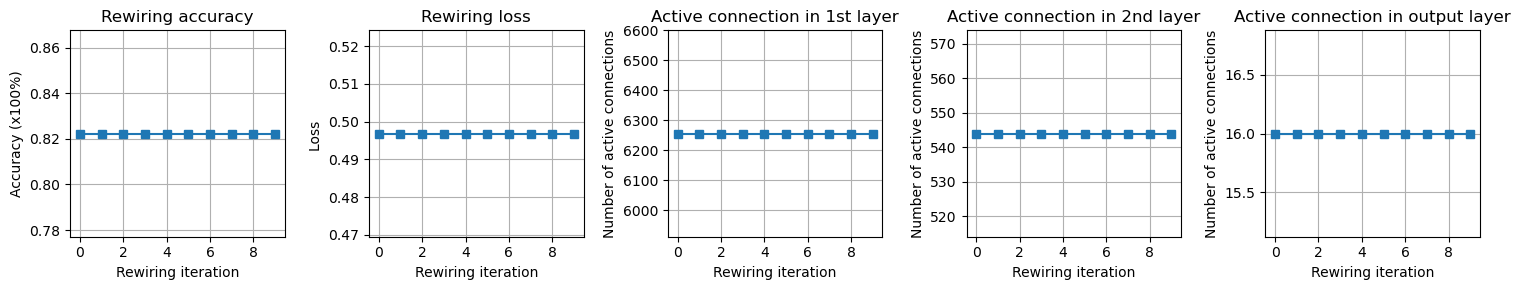

In [31]:
fig = plt.figure(figsize = (15,3))
plt.subplot(1,5,1)
plt.plot(list(range(10)), [Rewiring_dict[i][-2][1] for i in range(10)], marker = 's')
plt.title('Rewiring accuracy')
plt.grid()
plt.ylabel('Accuracy (x100%)')
plt.xlabel('Rewiring iteration')

plt.subplot(1,5,2)
plt.plot(list(range(10)), [Rewiring_dict[i][-2][0] for i in range(10)], marker = 's')
plt.title('Rewiring loss')
plt.grid()
plt.ylabel('Loss ')
plt.xlabel('Rewiring iteration')

plt.subplot(1,5,3)
plt.plot(list(range(10)), [Rewiring_dict[i][0][1][1] for i in range(10)], marker = 's')
plt.title('Active connection in 1st layer')
plt.grid()
plt.ylabel('Number of active connections')
plt.xlabel('Rewiring iteration')

plt.subplot(1,5,4)
plt.plot(list(range(10)), [Rewiring_dict[i][1][1][1] for i in range(10)], marker = 's')
plt.title('Active connection in 2nd layer')
plt.grid()
plt.ylabel('Number of active connections')
plt.xlabel('Rewiring iteration')

plt.subplot(1,5,5)
plt.plot(list(range(10)), [Rewiring_dict[i][2][1][1] for i in range(10)], marker = 's')
plt.title('Active connection in output layer')
plt.grid()
plt.ylabel('Number of active connections')
plt.xlabel('Rewiring iteration')

plt.tight_layout()

##### Plotting the distribution of parameters (thetas).

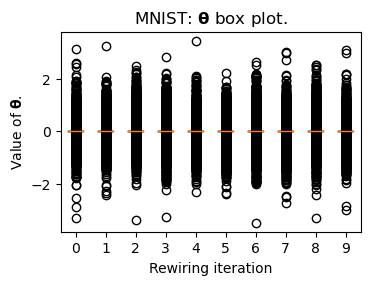

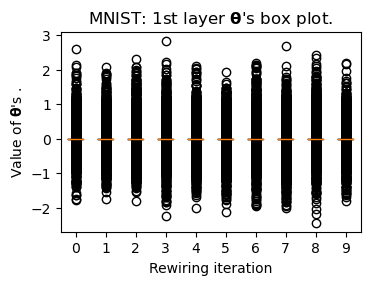

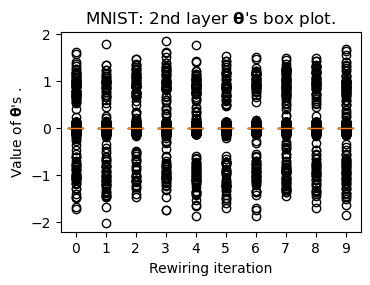

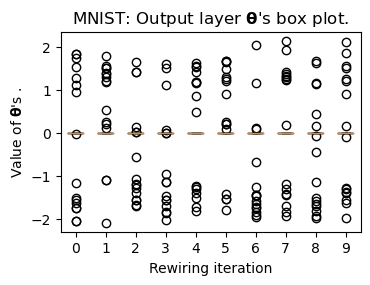

In [34]:
import itertools
import pdb
import collections

def flatten(weights):
    w = []
    for l in weights:
        if isinstance(l, collections.Iterable):
            w = w + flatten(l)
        else:
            w = w + [l]
    return w


all_weights = {}
boxplot_data = []
weights = [Rewiring_dict[i][-1] for i in range(10)]
for i,task in enumerate(weights):
    all_weights[i+1] = flatten(task)
    boxplot_data.append(all_weights[i+1])
import matplotlib
font = {'family' : 'normal',
        'weight'  : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (3,2))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(boxplot_data) 
ax.set_xlabel(r'Rewiring iteration')
plt.title(r"MNIST: $\mathbf{\theta}$ box plot.")
ax.set_ylabel(r"Value of $\mathbf{\theta}$.")
ax.set_xticklabels(list(range(10)))
plt.savefig('MNIST_params_rewiring.png', bbox_inches='tight')
plt.show()



all_weights = {}
boxplot_data = []
weights = [Rewiring_dict[i][-1] for i in range(10)]
for i,task in enumerate(weights):
    for j,layer in enumerate(task):
        if j%2==0:
            all_weights[i+1] = flatten(layer)
            boxplot_data.append(all_weights[i+1])
            
first_layer_weights =  boxplot_data[0::3]
second_layer_weights = boxplot_data[1::3]
output_layer_weights = boxplot_data[2::3]

fig = plt.figure(figsize =(3, 2))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(first_layer_weights) 
ax.set_xlabel(r'Rewiring iteration')
plt.title(r"MNIST: 1st layer $\mathbf{\theta}$'s box plot.")
ax.set_ylabel(r"Value of $\mathbf{\theta}$'s .")
ax.set_xticklabels(list(range(10)))
#plt.savefig('MNIST_params_boxplot.pdf', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize =(3, 2))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(second_layer_weights) 
ax.set_xlabel(r'Rewiring iteration')
plt.title(r"MNIST: 2nd layer $\mathbf{\theta}$'s box plot.")
ax.set_ylabel(r"Value of $\mathbf{\theta}$'s .")
ax.set_xticklabels(list(range(10)))
#plt.savefig('MNIST_params_boxplot.pdf', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize =(3, 2))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(output_layer_weights) 
ax.set_xlabel(r'Rewiring iteration')
plt.title(r"MNIST: Output layer $\mathbf{\theta}$'s box plot.")
ax.set_ylabel(r"Value of $\mathbf{\theta}$'s .")
ax.set_xticklabels(list(range(10)))
#plt.savefig('MNIST_params_boxplot.pdf', bbox_inches='tight')
plt.show()

## 4. Sparsity and Layer size Tuning

In [35]:
#Sweeping the sparsity and layersize (number of neurons in hidden layers) and measuring the model accuracy
model_losses = []
model_accs = []
Layerwise_sparsity = []
model_sparsity = []
Model_number_of_params = []
Model_weights_collection = []
for (first_layer_size,second_layer_size) in zip(range(100,500,50),range(50,250,20)):
    model = Sequential()
    model.add(Dense(first_layer_size, input_shape=(784,)))
    model.add(Activation('relu'))                            
    model.add(Dense(second_layer_size))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    layerwise_sparsity = []
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    for sparsity in range(10):
        print(f'Model training for sparsity # {sparsity+1}, layer size {first_layer_size,second_layer_size}.')
        class LossHistory(keras.callbacks.Callback):
            def on_train_begin(self, logs={}):
                self.losses = []
                self.batches = []
                self.weight_save = []
                self.model_weights = model.get_weights()
                self.weight_masks = []
                for i in range(len(self.model_weights)):
                    if i%2 == 0:
                        self.random_mask = np.logical_and(np.random.randint(0,2,self.model_weights[i].shape), np.random.randint(0,2,self.model_weights[i].shape))
                        for j in range(sparsity):
                            self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                        self.weight_masks.append(self.random_mask)
                for i in range(len(self.model_weights)):
                    if i == 0:
                        self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
                model.set_weights(self.model_weights)
                self.weight_save.append(model.get_weights)       

            def on_batch_end(self, batch, logs={}):
                self.losses.append(logs.get('loss'))
                self.batches.append(batch)
                self.model_weights = model.get_weights()
                for i in range(len(self.model_weights)):
                    if i %2 == 0:
                        self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
                model.set_weights(self.model_weights)
                self.weight_save.append(model.get_weights) 

        l_history=LossHistory()
        history = model.fit(X_train, Y_train,
                  batch_size=128, epochs=10, verbose=0,
                  validation_data=(X_test, Y_test), callbacks = [es, l_history])

        loss_and_metrics = model.evaluate(X_test, Y_test, verbose=2)
        model_losses.append(loss_and_metrics[0])
        model_accs.append(loss_and_metrics[1])

        for i in range(len(model.get_weights())):
            if i%2==0:
                layerwise_sparsity.append(1 - (np.count_nonzero(model.get_weights()[i])+0.0)/model.get_weights()[i].size)
        model_sparsity.append(np.mean(layerwise_sparsity))
        Layerwise_sparsity.append(layerwise_sparsity)
        Model_number_of_params.append(model.count_params())
        Model_weights_collection.append(model.get_weights())
        layerwise_sparsity = []

Model_nonzero_params = []
Average_weight_val = []
for weight in enumerate(Model_weights_collection):
    flattened_weight_lst = flatten(weight)
    Model_nonzero_params.append(np.count_nonzero(flattened_weight_lst))
    Average_weight_val.append(np.mean(flattened_weight_lst))

Model training for sparsity # 1, layer size (100, 50).
313/313 - 0s - loss: 0.1319 - accuracy: 0.9616 - 318ms/epoch - 1ms/step
Model training for sparsity # 2, layer size (100, 50).
313/313 - 0s - loss: 0.1832 - accuracy: 0.9457 - 319ms/epoch - 1ms/step
Model training for sparsity # 3, layer size (100, 50).
313/313 - 0s - loss: 0.2889 - accuracy: 0.9162 - 327ms/epoch - 1ms/step
Model training for sparsity # 4, layer size (100, 50).
313/313 - 0s - loss: 0.7035 - accuracy: 0.7610 - 287ms/epoch - 915us/step
Model training for sparsity # 5, layer size (100, 50).
313/313 - 0s - loss: 1.9710 - accuracy: 0.2879 - 258ms/epoch - 823us/step
Model training for sparsity # 6, layer size (100, 50).
313/313 - 0s - loss: 2.1756 - accuracy: 0.2288 - 259ms/epoch - 829us/step
Model training for sparsity # 7, layer size (100, 50).
313/313 - 0s - loss: 2.3010 - accuracy: 0.1135 - 241ms/epoch - 770us/step
Model training for sparsity # 8, layer size (100, 50).
313/313 - 0s - loss: 2.3011 - accuracy: 0.1135 -

Model training for sparsity # 1, layer size (400, 170).
313/313 - 0s - loss: 0.0769 - accuracy: 0.9773 - 478ms/epoch - 2ms/step
Model training for sparsity # 2, layer size (400, 170).
313/313 - 0s - loss: 0.0886 - accuracy: 0.9734 - 388ms/epoch - 1ms/step
Model training for sparsity # 3, layer size (400, 170).
313/313 - 1s - loss: 0.1469 - accuracy: 0.9581 - 565ms/epoch - 2ms/step
Model training for sparsity # 4, layer size (400, 170).
313/313 - 1s - loss: 0.2289 - accuracy: 0.9336 - 550ms/epoch - 2ms/step
Model training for sparsity # 5, layer size (400, 170).
313/313 - 1s - loss: 0.7143 - accuracy: 0.7797 - 525ms/epoch - 2ms/step
Model training for sparsity # 6, layer size (400, 170).
313/313 - 0s - loss: 1.5127 - accuracy: 0.4796 - 468ms/epoch - 1ms/step
Model training for sparsity # 7, layer size (400, 170).
313/313 - 0s - loss: 2.1325 - accuracy: 0.1965 - 342ms/epoch - 1ms/step
Model training for sparsity # 8, layer size (400, 170).
313/313 - 0s - loss: 2.3010 - accuracy: 0.1135 -

##### Plotting the metrics

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


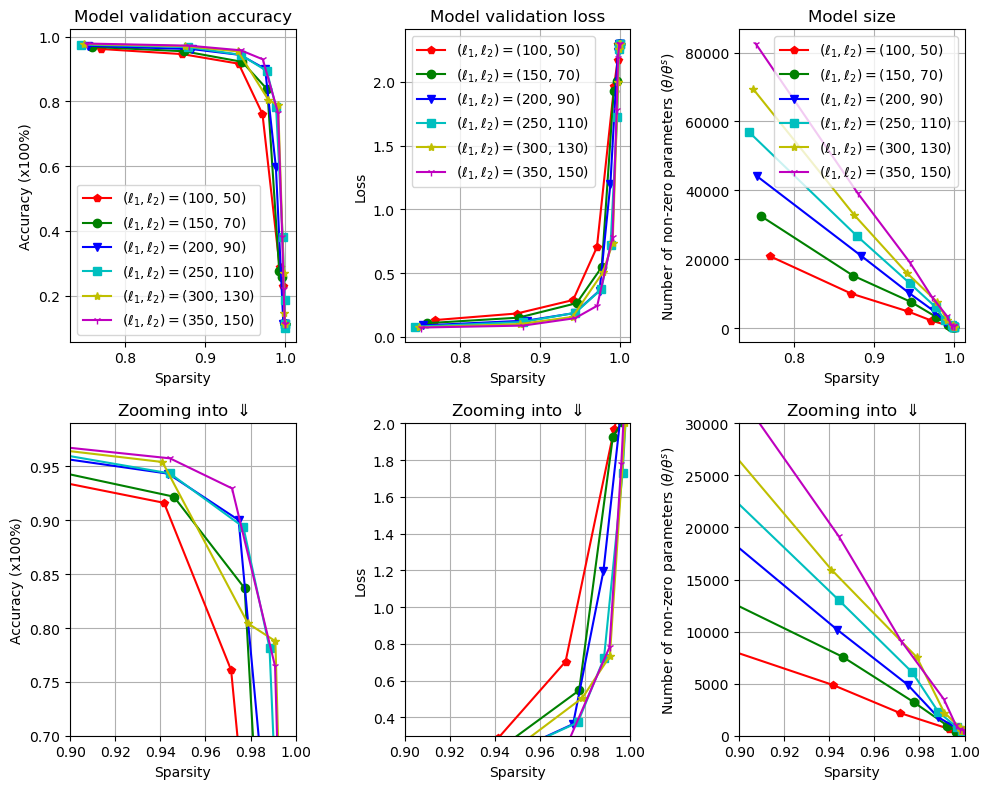

In [62]:
fig = plt.figure(figsize = (10,8))
sparsity_iters = 0
for (first_layer_size,second_layer_size,c,m) in zip(range(100,500,50),range(50,250,20),['r','g','b','c','y', 'm'],['p','o','v','s','*','1','2','3','4']):
    plt.subplot(2,3,1)
    plt.plot(model_sparsity[sparsity_iters*10:sparsity_iters*10+10], model_accs[sparsity_iters*10:sparsity_iters*10+10], color = c, marker = m, label = r'$(\ell_1,\ell_2)=$'+ f'{first_layer_size,second_layer_size}')
    plt.title('Model validation accuracy')
    plt.grid(True)
    plt.ylabel('Accuracy (x100%)')
    plt.xlabel('Sparsity')
    plt.legend()
    
    plt.subplot(2,3,2)
    plt.plot(model_sparsity[sparsity_iters*10:sparsity_iters*10+10], model_losses[sparsity_iters*10:sparsity_iters*10+10], color = c, marker = m, label = r'$(\ell_1,\ell_2)=$'+ f'{first_layer_size,second_layer_size}')
    plt.title('Model validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Sparsity')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(2,3,4)
    plt.plot(model_sparsity[sparsity_iters*10:sparsity_iters*10+10], model_accs[sparsity_iters*10:sparsity_iters*10+10], color = c, marker = m, label = r'$(\ell_1,\ell_2)=$'+ f'{first_layer_size,second_layer_size}')
    plt.title(r'Zooming into $\Downarrow$')
    plt.grid(True)
    plt.ylabel('Accuracy (x100%)')
    plt.xlabel('Sparsity')
    plt.xlim(0.9,1)
    plt.ylim(0.7,0.99)
    #plt.legend()
    
    plt.subplot(2,3,5)
    plt.plot(model_sparsity[sparsity_iters*10:sparsity_iters*10+10], model_losses[sparsity_iters*10:sparsity_iters*10+10], color = c, marker = m, label = r'$(\ell_1,\ell_2)=$'+ f'{first_layer_size,second_layer_size}')
    plt.title(r'Zooming into $\Downarrow$')
    plt.ylabel('Loss')
    plt.xlabel('Sparsity')
    plt.grid(True)
    #plt.legend()
    plt.xlim(0.9,1)
    plt.ylim(0.3,2)
    plt.tight_layout()
    
    plt.subplot(2,3,3)
    plt.plot(model_sparsity[sparsity_iters*10:sparsity_iters*10+10], Model_nonzero_params[sparsity_iters*10:sparsity_iters*10+10], color = c, marker = m, label = r'$(\ell_1,\ell_2)=$'+ f'{first_layer_size,second_layer_size}')
    plt.title('Model size')
    plt.grid(True)
    plt.ylabel(r"Number of non-zero parameters ($\theta / \theta^s$)")
    plt.xlabel('Sparsity')
    plt.legend()
    
    plt.subplot(2,3,6)
    plt.plot(model_sparsity[sparsity_iters*10:sparsity_iters*10+10], Model_nonzero_params[sparsity_iters*10:sparsity_iters*10+10], color = c, marker = m, label = r'$(\ell_1,\ell_2)=$'+ f'{first_layer_size,second_layer_size}')
    plt.title(r'Zooming into $\Downarrow$')
    plt.grid(True)
    plt.ylabel(r"Number of non-zero parameters ($\theta / \theta^s$)")
    plt.xlabel('Sparsity')
    #plt.legend()
    plt.xlim(0.9,1)
    plt.ylim(0,30000)
    
    sparsity_iters = sparsity_iters+1
plt.savefig('MNIST_sparsity_layer_sweep.pdf', bbox_inches='tight')

##### 3d plot

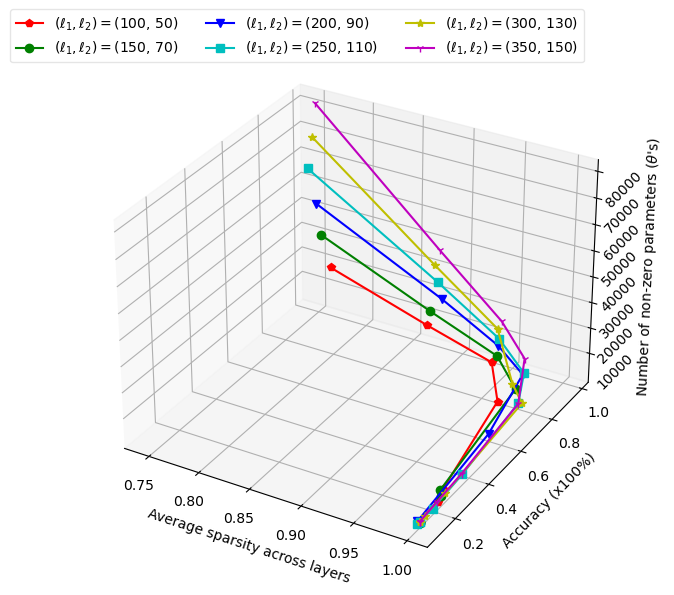

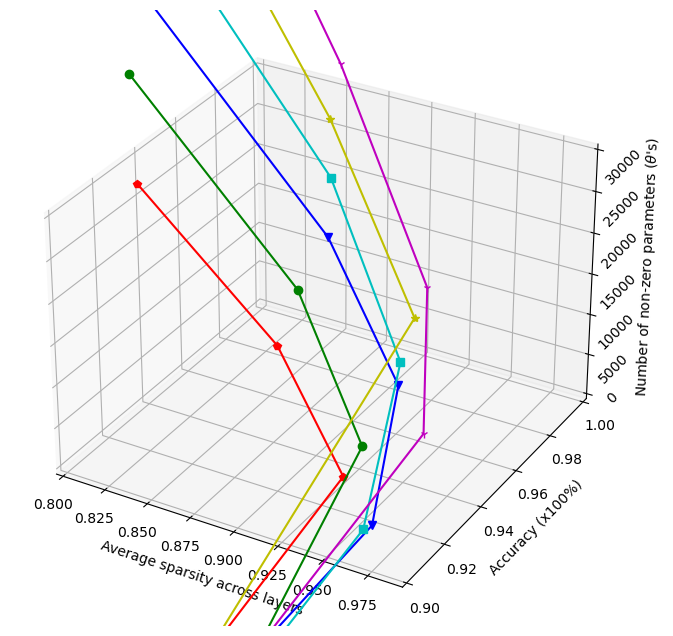

In [47]:
fig = plt.figure(figsize = (10,7))
ax = plt.axes(projection='3d')
sparsity_iters = 0
for (first_layer_size,second_layer_size,c,m) in zip(range(100,500,50),range(50,250,20),['r','g','b','c','y', 'm'],['p','o','v','s','*','1','2','3','4']):
    xline = model_sparsity[sparsity_iters*10:sparsity_iters*10+10]
    yline = model_accs[sparsity_iters*10:sparsity_iters*10+10]
    zline = Model_nonzero_params[sparsity_iters*10:sparsity_iters*10+10]
    ax.plot3D(xline, yline, zline, color = c, marker = m, label = r'$(\ell_1,\ell_2)=$'+ f'{first_layer_size,second_layer_size}')
    #ax.set_title('Model testing accuracy vs sparsity vs no. of connections.')
    ax.grid()
    ax.set_ylabel('Accuracy (x100%)')
    ax.set_xlabel('Average sparsity across layers')
    ax.set_zlabel(r"Number of non-zero parameters ($\theta$'s)")
    for tick in ax.get_zticklabels():
        tick.set_rotation(45)
    ax.legend(ncol=3, loc='lower left', fancybox=True, framealpha=0.5, bbox_to_anchor=(-0.15, 0.950))
    sparsity_iters = sparsity_iters+1
    
fig = plt.figure(figsize = (10,8))
ax = plt.axes(projection='3d')
sparsity_iters = 0
for (first_layer_size,second_layer_size,c,m) in zip(range(100,500,50),range(50,250,20),['r','g','b','c','y', 'm'],['p','o','v','s','*','1','2','3','4']):
    xline = model_sparsity[sparsity_iters*10:sparsity_iters*10+10]
    yline = model_accs[sparsity_iters*10:sparsity_iters*10+10]
    zline = Model_nonzero_params[sparsity_iters*10:sparsity_iters*10+10]
    ax.plot3D(xline, yline, zline, color = c, marker = m, label = r'$(\ell_1,\ell_2)=$'+ f'{first_layer_size,second_layer_size}')
    #ax.set_title('Model testing accuracy vs sparsity vs no. of connections.')
    ax.grid()
    ax.set_ylabel('Accuracy (x100%)')
    ax.set_xlabel('Average sparsity across layers')
    ax.set_zlabel(r"Number of non-zero parameters ($\theta$'s)")
    for tick in ax.get_zticklabels():
        tick.set_rotation(45)
    #ax.legend(ncol=3, loc='lower left', fancybox=True, framealpha=0.5, bbox_to_anchor=(-0.15, 0.950))
    ax.set_xlim(0.8,0.99)
    ax.set_ylim(0.9,1)
    ax.set_zlim(0, 30000)    
    sparsity_iters = sparsity_iters+1

##### Showing the summary of results as dataframe

In [48]:
import pandas as pd
df = pd.DataFrame(list(zip(list(range(100,500,50))*len(list(range(10))), list(range(50,250,20))*len(list(range(10))), model_sparsity, model_accs, model_losses, Model_nonzero_params, Model_number_of_params, Average_weight_val)),
               columns =[r'$\ell_1$', r'$\ell_1$', 'Sparsity', 'Validation Acc', 'Validation Loss', r'Nonzero $|\theta|$', r'$|\theta|$', r'Centroid of $\theta$' ])
print(df.to_string())

    $\ell_1$  $\ell_1$  Sparsity  Validation Acc  Validation Loss  Nonzero $|\theta|$  $|\theta|$  Centroid of $\theta$
0        100        50  0.769394          0.9616         0.131913               20882       84060              0.005350
1        150        70  0.871192          0.9457         0.183184               10011       84060              0.002555
2        200        90  0.941605          0.9162         0.288913                4873       84060              0.003255
3        250       110  0.971384          0.7610         0.703513                2181       84060              0.001748
4        300       130  0.992980          0.2879         1.971041                 666       84060              0.000622
5        350       150  0.997383          0.2288         2.175599                 221       84060              0.000777
6        400       170  0.997757          0.1135         2.301026                 177       84060              0.000782
7        450       190  0.999333        

##### Finding the smallest network size with accuracy more than 90%.

In [58]:
df = df.sort_values(by=[r'Nonzero $|\theta|$', 'Validation Acc'], ascending=True)
print(f"The smallest network with accuracy more than 90% is:\n{df.loc[df['Validation Acc'] > 0.9].iloc[0]}")
print('\nOther options for the accuracy > 90% is:')
sdf = df.loc[df['Validation Acc'].round(3) > 0.9]
sdf

The smallest network with accuracy more than 90% is:
$\ell_1$                  200.000000
$\ell_1$                   90.000000
Sparsity                    0.941605
Validation Acc              0.916200
Validation Loss             0.288913
Nonzero $|\theta|$       4873.000000
$|\theta|$              84060.000000
Centroid of $\theta$        0.003255
Name: 2, dtype: float64

Other options for the accuracy > 90% is:


,$\ell_1$,$\ell_1$,Sparsity,Validation Acc,Validation Loss,Nonzero $|\theta|$,$|\theta|$,Centroid of $\theta$
2,200,90,0.941605,0.9162,0.288913,4873,84060,0.003255
12,300,90,0.945974,0.9219,0.264279,7570,129030,0.001381
53,350,110,0.971807,0.9296,0.244130,9127,328910,0.001370
1,150,70,0.871192,0.9457,0.183184,10011,84060,0.002555
22,400,90,0.943422,0.9433,0.186692,10194,176000,0.001412
63,450,110,0.974962,0.9336,0.228893,10511,383880,0.001272
73,150,110,0.975001,0.9348,0.215994,11919,440850,0.000967
32,100,90,0.944229,0.9435,0.188803,13021,224970,0.001554
11,250,70,0.873349,0.9545,0.150629,15239,129030,0.003352
42,200,90,0.940895,0.9541,0.156316,15959,275940,0.000976


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


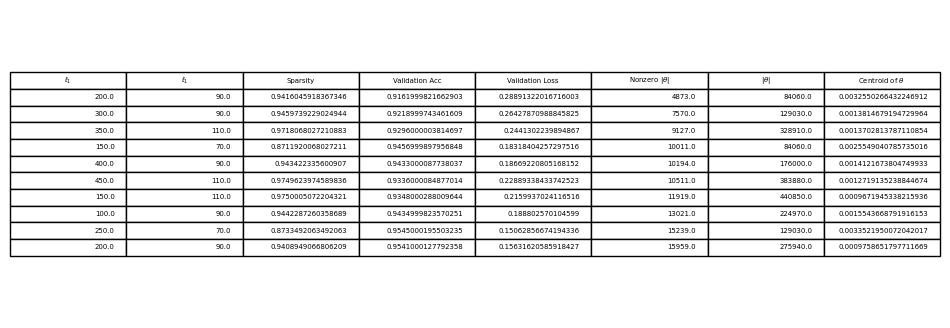

In [60]:
fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=sdf[:10].values,colLabels=sdf.columns,loc='center')

In [61]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages("pandas_frame.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()